In [105]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


sns.set(color_codes=True)

In [106]:
def mse(y_test, y_true):
    return np.mean((y_test - y_true) ** 2)

def expo_fit(y):
    x = np.arange(-y.shape[0], 0)
    return np.exp(np.polyfit(x, np.log(y), 1)[1])

### Step I: Import the data that has already been cleaned and merged

In [107]:
data = pd.read_csv("all_in_1.csv")

X, y = data.drop(columns=['4/18/20']), data['4/18/20']

### Step II: Visualizations (Feel free to skip this part if you want)

In [108]:
results = []
for j in range(86,89):
    result = []
    for i in range(j-12, j-2):
        y_mat = X.iloc[:,i:j].to_numpy()
        exp_predict = np.apply_along_axis(expo_fit, 1, y_mat)
        exp_predict[np.isnan(exp_predict)] = 0
        result.append(mse(exp_predict, X.iloc[:,j]))
    results.append(result)

# special handling for interpolating 4/18/20 data
result = []
for i in range(78, 88):
    y_mat = X.iloc[:,i:90].to_numpy()
    exp_predict = np.apply_along_axis(expo_fit, 1, y_mat)
    exp_predict[np.isnan(exp_predict)] = 0
    result.append(mse(exp_predict, y))

results.append(result)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


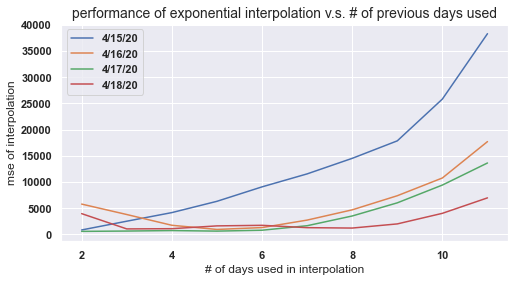

In [109]:
x = np.arange(11, 1, -1)
labels = ['4/15/20', '4/16/20', '4/17/20', '4/18/20']
plt.figure(figsize=(8, 4))
for i in range(4):
    plt.plot(x, results[i], label=labels[i])
plt.legend()
plt.ylabel("mse of interpolation")
plt.xlabel("# of days used in interpolation")
plt.title("performance of exponential interpolation v.s. # of previous days used", fontsize=14);

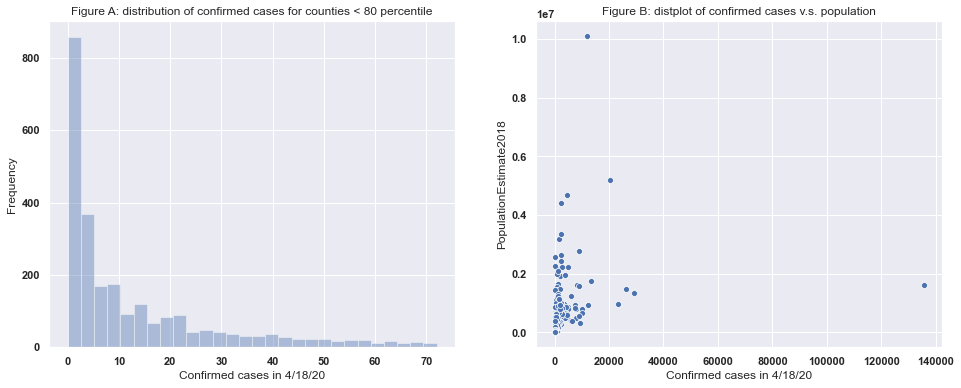

In [110]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(y[y < np.percentile(y, 80)], kde=False)
plt.xlabel("Confirmed cases in 4/18/20")
plt.ylabel("Frequency")
plt.title("Figure A: distribution of confirmed cases for counties < 80 percentile");

plt.subplot(1, 2, 2)
sns.scatterplot(x="4/18/20", y="PopulationEstimate2018", data=data)
plt.xlabel("Confirmed cases in 4/18/20")
plt.title("Figure B: distplot of confirmed cases v.s. population");

In [111]:
X.shape

(3140, 164)

### 2.5 Feature Selection using KNN

In [112]:
X_KNN, y_KNN = data.loc[:, ['Lat_x', 'Long_']], data['4/18/20']

In [113]:
def dist_metric(loc1, loc2):
    lat1, lon1, lat2, lon2  = loc1[0], loc1[1], loc2[0], loc2[1]
    p = 0.017453292519943295 # Pi / 180
    a = 0.5 - np.cos((lat2 - lat1) * p) / 2 + np.cos(lat1 * p) * np.cos(lat2 * p) * \
    (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(a ** 2) # 12742 = 2 * R

In [114]:
neigh = KNeighborsRegressor(n_neighbors=2, weights = 'distance', metric = dist_metric)
neigh.fit(X_KNN, y_KNN)


KNeighborsRegressor(algorithm='auto', leaf_size=30,
                    metric=<function dist_metric at 0x12909e320>,
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='distance')

Text(0.5, 1.0, 'counties by position')

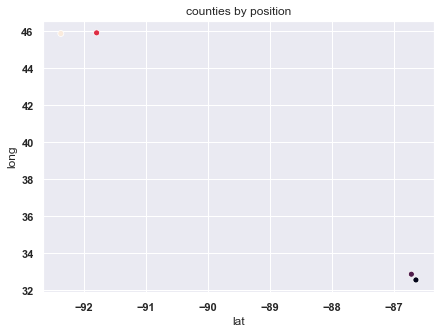

In [115]:
# testing 
neighbours = list(neigh.kneighbors([[32.539527, -86.644082]])[1][0]) + list(neigh.kneighbors([[45.898386, -91.790504]])[1][0])
neighbour_locations = X.loc[neighbours, :]

fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.scatterplot(x="Long_", y="Lat_x", data=neighbour_locations)

plt.xlabel('lat')
plt.ylabel('long')
plt.title('counties by position')

In [116]:
clusters = neigh.kneighbors()[1]

In [117]:
neighbour_dict = {i: clusters[i] for i in X.index}

In [118]:
# ref_pop is the poplation of the county being referenced to, neigh_pop is the population of one of its neighbor counties
# counts, neigh_pops are np arrays, ref_pop is is an integer
def normalize_by_pop(stat_mat, neigh_pops, ref_pop):
    factors = [ref_pop/n_pop for n_pop in neigh_pops]
    weighted_sums = stat_mat @ factors
    return list(weighted_sums / len(neigh_pops))
 

f = ['4/15/20','4/16/20','4/17/20']
f_new = ['4/15/20_neigh_nor','4/16/20_neigh_nor','4/17/20_neigh_nor']

new_feature_list = []


In [119]:
for i in X.index:
    neigh_id = neighbour_dict.get(i)

    ref_pop = X.loc[i, 'PopulationEstimate2018']
    neigh_pops = X.loc[neigh_id, 'PopulationEstimate2018']
    stat_matrix = np.transpose(X.loc[neigh_id, f]) # a len(f) by num_neigh matrix
    
    new_feature_list.append(normalize_by_pop(stat_matrix, neigh_pops, ref_pop))

In [120]:
new_feature_df = pd.DataFrame(np.array(new_feature_list), columns=f_new)

X_new = pd.concat([X, new_feature_df], axis=1)

### 3. Simple Regressors (LinearRegression v.s. DecisionTree)

In [121]:
features = ['4/15/20', 
            '4/16/20', 
            '4/17/20', 
            'dem_to_rep_ratio', 
            'PopulationDensityperSqMile2010', 
            'public schools',
            'FracMale2017',
            'DiabetesPercentage',
            'People_Tested',
            'HeartDiseaseMortality'] + f_new
X_train, X_test, y_train, y_test = train_test_split(X_new[features], y, test_size=0.1, random_state=42)

In [122]:
linear_regr = LinearRegression(normalize=True)
linear_regr.fit(X_train, y_train)

tree_regr = DecisionTreeRegressor(max_depth=20, random_state=80)
tree_regr.fit(X_train, y_train)

linear_pred = np.round(np.maximum(0, linear_regr.predict(X_test)))
linear_mse = mse(linear_pred, y_test)
tree_pred = np.round(tree_regr.predict(X_test))
tree_mse = mse(tree_pred, y_test)

linear_mse, tree_mse

(119.7484076433121, 262.6528662420382)

#### Check the mse for prediction of counties with small confirmed cases

In [123]:
small_indices = np.argwhere(y_test < 50).flatten()
a = y_test.to_numpy()[small_indices]
"""
Linear
"""
b = linear_pred[small_indices]
"""
Decision Tree
"""
c = tree_pred[small_indices]

print(f"Linear mse: {mse(a, b)}, Tree mse: {mse(a, c)}")

Linear mse: 62.15853658536585, Tree mse: 2.638211382113821


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [124]:
big_indices = np.argwhere(y_test >= 50).flatten()
a = y_test.to_numpy()[big_indices]
"""
Linear
"""
b = linear_pred[big_indices]
"""
Decision Tree
"""
c = tree_pred[big_indices]

print(f"Linear mse: {mse(a, b)}, Tree mse: {mse(a, c)}")

Linear mse: 328.0882352941176, Tree mse: 1203.2941176470588


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [125]:
class finalRegressor(object):
    def __init__(self, threshold=50, forest=False, randstate=42):
        self.thres = threshold
        if forest:
            self.tree_regr = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=randstate)
        else:
            self.tree_regr = DecisionTreeRegressor(max_depth=20, random_state=randstate)
        self.linear_regr = LinearRegression(normalize=True)
    
    def fit(self, X_train, y_train):
        self.tree_regr.fit(X_train, y_train)
        self.linear_regr.fit(X_train, y_train)
        self.thres_val = np.percentile(y_train, self.thres)
    
    def predict(self, X_test):
        self.linear_pred = np.maximum(self.linear_regr.predict(X_test), 0)
        self.tree_pred = self.tree_regr.predict(X_test)
        self.cond_vec = ((self.linear_pred + self.tree_pred) / 2) < self.thres_val
        return np.round(self.tree_pred * self.cond_vec + self.linear_pred * ~self.cond_vec)


In [126]:
thresh_results = []

for thres in range(20, 100):
    final_regr = finalRegressor(thres)
    final_regr.fit(X_train, y_train)
    final_pred = final_regr.predict(X_test)
    thresh_results.append(mse(final_pred, y_test))

In [127]:
min(thresh_results), np.mean(thresh_results),  np.std(thresh_results)

(70.49044585987261, 109.66054936305731, 53.496319546696206)

In [128]:
thresh_results

[119.64968152866243,
 119.64968152866243,
 119.19426751592357,
 119.19426751592357,
 119.19426751592357,
 119.19426751592357,
 119.19426751592357,
 119.19426751592357,
 118.2484076433121,
 118.2484076433121,
 118.2484076433121,
 118.2484076433121,
 117.5732484076433,
 117.5732484076433,
 117.5732484076433,
 117.5732484076433,
 116.93949044585987,
 116.93949044585987,
 116.93949044585987,
 116.73885350318471,
 116.73885350318471,
 116.73885350318471,
 116.34713375796179,
 116.34713375796179,
 116.34713375796179,
 116.21656050955414,
 116.21656050955414,
 116.03821656050955,
 115.51592356687898,
 115.51592356687898,
 114.11464968152866,
 114.10191082802548,
 114.10191082802548,
 112.40127388535032,
 112.40127388535032,
 112.30573248407643,
 112.30254777070064,
 112.0732484076433,
 112.03821656050955,
 111.53184713375796,
 111.36624203821655,
 111.31847133757962,
 111.1624203821656,
 111.14331210191082,
 111.12101910828025,
 110.67834394904459,
 110.05414012738854,
 108.97133757961784,
 1

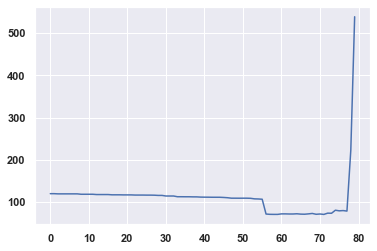

In [129]:
plt.plot(thresh_results)

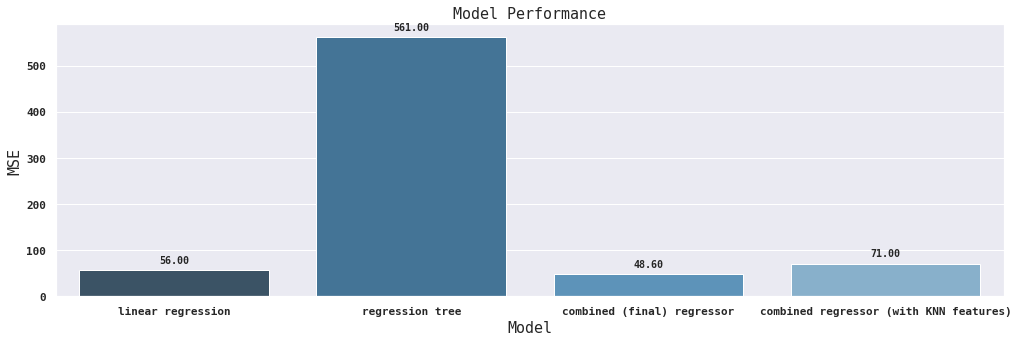

In [160]:
df = pd.DataFrame([["linear regression", 56],
                   ['regression tree', 561],
                   ["combined (final) regressor", 48.6],
                   ["combined regressor (with KNN features)", 71]],
                  columns = ["model", "MSE"])



fig, ax = plt.subplots(figsize=(17, 5))

sns.barplot(x="model", y="MSE", palette="Blues_d", data=df)

plt.xlabel('Model', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('Model Performance', fontsize = 15)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
             (p.get_x() + p.get_width() / 2,
              p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 10), 
             textcoords = 'offset points')

In [131]:
plt.rc?

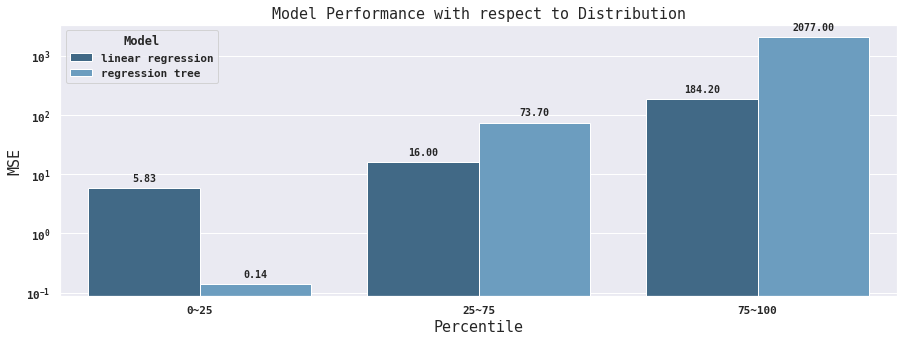

In [157]:
df = pd.DataFrame([["linear regression", "0~25", 5.83],
                   ["linear regression", "25~75", 16],
                   ["linear regression", "75~100", 184.2],
                   ['regression tree', "0~25", 0.14],
                  ['regression tree', "25~75", 73.7],
                  ['regression tree', "75~100", 2077]],
                  columns = ["Model", "percentile", "MSE"])

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(yscale="log")
sns.barplot(x = "percentile", y = "MSE", hue = "Model", palette="Blues_d", data=df)

plt.xlabel('Percentile', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('Model Performance with respect to Distribution', fontsize = 15)
plt.ylim

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
             (p.get_x() + p.get_width() / 2,
              p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 10), 
             textcoords = 'offset points')



In [151]:
ax.text?